In [1]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

2023-08-29 14:03:29.359825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:03:29.660911: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-29 14:03:29.710826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-29 14:03:30.397523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import os
import preprocessing
from glob import glob
from generators import RandomPatientSliceGenerator

DATASET_PATH = f"{os.path.expanduser('~')}/Datasets/segthor_extracted"
IMG_SHAPE = (256, 256)
N_CHANNELS = 1
INPUT_SHAPE = IMG_SHAPE + (N_CHANNELS,)
N_CLASSES = 1
OUTPUT_SHAPE = IMG_SHAPE + (N_CLASSES,)
BATCH_SIZE = 20

# train - val
tmp_train_patients = glob(f"{DATASET_PATH}/train/Patient*/")
idx_train = int(len(tmp_train_patients)*0.9)
train_patients = tmp_train_patients[:idx_train] # ~90% da base (25 pacientes)
val_patients = tmp_train_patients[idx_train + 1:] # ~10% da base (3 pacientes)

preprocessing_pipeline = preprocessing.Pipeline([
    preprocessing.windowing(-500, 60),
    preprocessing.norm, 
    preprocessing.resize(IMG_SHAPE),
    preprocessing.expand_dims
])

train_dataset = tf.data.Dataset.from_generator(
    RandomPatientSliceGenerator(train_patients, preprocessing_pipeline),
    output_signature =
    (
        tf.TensorSpec(shape=INPUT_SHAPE),
        tf.TensorSpec(shape=OUTPUT_SHAPE)
    ),
).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    RandomPatientSliceGenerator(val_patients, preprocessing_pipeline),
    output_signature=
    (
        tf.TensorSpec(shape=INPUT_SHAPE),
        tf.TensorSpec(shape=OUTPUT_SHAPE)
    )
).batch(BATCH_SIZE)


2023-08-29 14:03:31.796150: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-29 14:03:31.796700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-29 14:03:31.797176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-29 14:03:31.797597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [3]:
from model import EfficientUnet

model = EfficientUnet(input_shape = INPUT_SHAPE)

Segmentation Models: using `keras` framework.


In [4]:
import segmentation_models as sm

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
precision_score = tf.keras.metrics.Precision(name="precision", thresholds=0.5)
recall_score = tf.keras.metrics.Recall(name="recall", thresholds=0.5)
f_score = sm.metrics.FScore(threshold=0.5)
iou_score = sm.metrics.IOUScore(threshold=0.5)

checkpoint_dir = f"records/{model.name}"
os.makedirs(checkpoint_dir+"/checkpoint", exist_ok=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f"{checkpoint_dir}/checkpoint/{model.name}",
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = True,
    save_freq='epoch',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    mode='min',
    factor=0.3,
    patience=5,
    cooldown=5,
    min_lr = 0.00001,
    min_delta=0.01
    )

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode='min',
    restore_best_weights=True,
    patience=10,
    min_delta=0.01
)

# compile
model.compile(optimizer, 
            loss      =   sm.losses.DiceLoss(),
            metrics   =   [
                precision_score,
                recall_score,
            ],
            weighted_metrics = [
                iou_score,
                f_score,      
            ])

In [5]:
EPOCHS = 30
# fit
H = model.fit(
    train_dataset,
    validation_data=val_dataset, 
    epochs=EPOCHS,
    callbacks=[checkpoint, lr_scheduler, early_stopping])

Epoch 1/30


2023-08-29 14:03:40.505061: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-29 14:03:41.479652: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


60/60 [==============================] - 38s 429ms/step - loss: 0.9188 - precision: 0.0347 - recall: 0.9552 - iou_score: 0.2807 - f1-score: 0.3779 - val_loss: 0.9136 - val_precision: 0.8869 - val_recall: 0.7221 - val_iou_score: 0.6691 - val_f1-score: 0.8011 - lr: 0.0010
Epoch 2/30
60/60 [==============================] - 21s 355ms/step - loss: 0.1913 - precision: 0.8906 - recall: 0.9196 - iou_score: 0.8310 - f1-score: 0.9068 - val_loss: 0.9235 - val_precision: 0.0971 - val_recall: 0.1103 - val_iou_score: 0.0558 - val_f1-score: 0.1054 - lr: 0.0010
Epoch 3/30
60/60 [==============================] - 22s 366ms/step - loss: 0.0739 - precision: 0.9410 - recall: 0.9386 - iou_score: 0.8869 - f1-score: 0.9400 - val_loss: 0.4157 - val_precision: 0.9678 - val_recall: 0.4566 - val_iou_score: 0.4561 - val_f1-score: 0.6243 - lr: 0.0010
Epoch 4/30
60/60 [==============================] - 22s 366ms/step - loss: 0.0611 - precision: 0.9503 - recall: 0.9450 - iou_score: 0.9005 - f1-score: 0.9476 - val_l

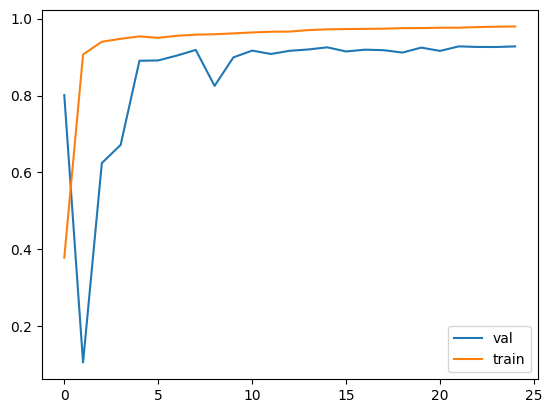

In [11]:
import matplotlib.pyplot as plt

val_f1_score = H.history["val_f1-score"]
train_f1_score = H.history["f1-score"]

plt.plot(val_f1_score)
plt.plot(train_f1_score)
plt.legend(["val", "train"])

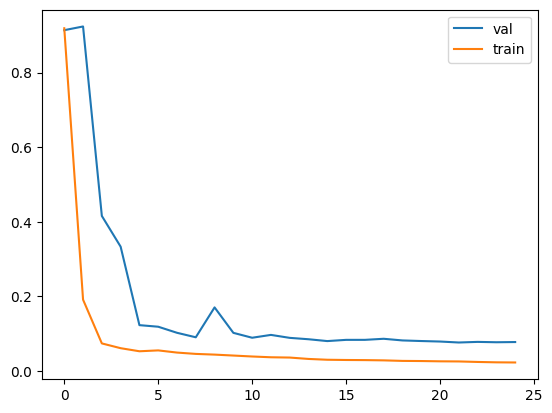

In [12]:
val_loss = H.history["val_loss"]
train_loss = H.history["loss"]

plt.plot(val_loss)
plt.plot(train_loss)
plt.legend(["val", "train"])

In [13]:
def read_volume_preds(folder):
    import cv2 as cv
    import numpy as np
    from glob import glob
    from pathlib import Path

    images = glob(f"{folder}/*")
    images.sort(key = lambda p: int(Path(p).name.replace(Path(p).suffix, "")))
    images = [cv.imread(img, cv.IMREAD_UNCHANGED) for img in images]

    return np.array(images)

def read_volume_dataset(folder):
    import cv2 as cv
    import numpy as np
    from glob import glob
    from pathlib import Path

    images = glob(f"{folder}/GT_*")
    images.sort(key = lambda p: int(Path(p).name.replace("GT_", "").replace(Path(p).suffix, "")))
    images = [cv.imread(img, cv.IMREAD_UNCHANGED) for img in images]
    return np.array(images)

def make_gif(volume1, volume2):
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation

    # figure = plt.figure()
    a = np.random.random((256, 256))

    figure, ax = plt.subplots(1, 2)
    im1 = ax[0].imshow(a, cmap="gray")
    im2 = ax[1].imshow(a, cmap="gray")
    # im = plt.imshow(a, cmap="gray")
    
    def fn(i):
        im1.set_data(volume1[i])
        im2.set_data(volume2[i])
        return [im1, im2]
    
    fps = volume1.shape[0]
    anim = FuncAnimation(figure, fn, frames=fps, interval=100)
    return anim

In [14]:
from glob import glob
from pathlib import Path
from generators import PerPatientSliceGenerator

patient_test = "/home/arthur_guilherme/Datasets/segthor_extracted/test/Patient_01/"

patient_dataset = tf.data.Dataset.from_generator(
    PerPatientSliceGenerator(patient_test, preprocessing_pipeline),
    output_signature=
    (
        tf.TensorSpec(shape=INPUT_SHAPE, dtype=tf.float32),
        tf.TensorSpec(shape=OUTPUT_SHAPE, dtype=tf.float32)
    )
)

In [43]:
import numpy as np
volume_true = []
for (x, y) in patient_dataset:
    volume_true.append(y)
volume_true = np.squeeze(np.array(volume_true))
volume_pred = model.predict(patient_dataset.batch(20))
volume_pred = np.round(volume_pred)
volume_pred = np.squeeze(volume_pred)

12/12 [==============================] - 1s 119ms/step


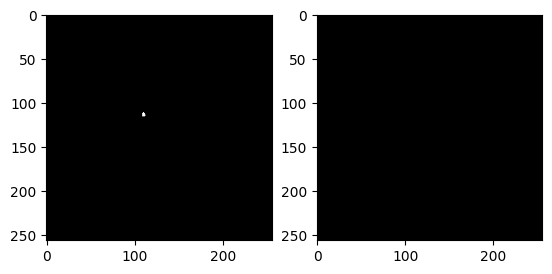

In [37]:
from IPython import display
video = make_gif(volume_pred, volume_true)
display.HTML(video.to_html5_video())

In [44]:
import tensorflow_advanced_segmentation_models as tasm
import tensorflow as tf

dice_score = tasm.metrics.FScore(threshold=0.5)
precision_score = tf.keras.metrics.Precision(thresholds=0.5)
recall_score = tf.keras.metrics.Recall(thresholds=0.5)
iou_score = tasm.metrics.IOUScore(threshold=0.5)

metrics = {
    "dice":dice_score(volume_true, volume_pred),
    "precision":precision_score(volume_true, volume_pred),
    "recall":recall_score(volume_true, volume_pred),
    "iou_score":iou_score(volume_true, volume_pred),
}

for k in metrics.keys():
    print(f"{k} : {metrics[k]}")

dice : 0.511206865310669
precision : 0.641478419303894
recall : 0.9271863102912903
iou_score : 0.5002907514572144


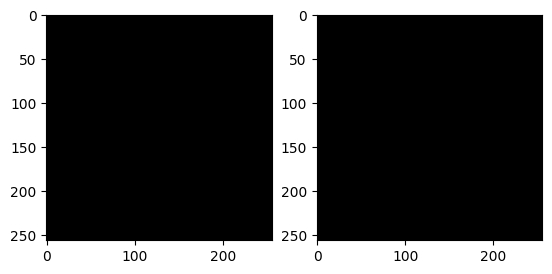

In [38]:
import SimpleITK as sitk

def biggest_object(volume):
    volume = volume.astype(np.int8)
    # for image in volume:
        # print(image)
        # image_sitk=sitk.ReadImage(image)
    image_sitk = sitk.GetImageFromArray(volume)
    image_sitk.SetOrigin((0, 0, 0))

    connected_filter = sitk.ConnectedComponentImageFilter()
    connected_filter.FullyConnectedOn()
    new_image = connected_filter.Execute(image_sitk)
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.Execute(new_image)
    maior_label=None
    qtd_maior_label=0
    for label in stats.GetLabels():
        if(stats.GetNumberOfPixels(label)>qtd_maior_label):
            maior_label=label
            qtd_maior_label=stats.GetNumberOfPixels(label)

    new_image_array=sitk.GetArrayFromImage(new_image)
    new_image_array[new_image_array!=maior_label]=0
    new_image_array[new_image_array==maior_label]=255
    new_image = sitk.GetImageFromArray(new_image_array)
    new_image.CopyInformation(image_sitk)
    return sitk.GetArrayFromImage(new_image)

new_volume_pred = biggest_object(volume_pred)
new_volume_pred = new_volume_pred.astype(np.float32)
from IPython import display
video = make_gif(new_volume_pred, volume_true)

display.HTML(video.to_html5_video())

In [45]:


metrics = {
    "dice":dice_score(volume_true, new_volume_pred),
    "precision":precision_score(volume_true, new_volume_pred),
    "recall":recall_score(volume_true, new_volume_pred),
    "iou_score":iou_score(volume_true, new_volume_pred),
}

for k in metrics.keys():
    print(f"{k} : {metrics[k]}")

dice : 0.8837023973464966
precision : 0.7298242449760437
recall : 0.9271863102912903
iou_score : 0.8733329772949219
